In [102]:
import numpy as np
from dataclasses import dataclass
import enum
import typing
import re

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import cmasher as cmr

# Part 1

In [89]:
class Dir(enum.IntEnum):
    N = 0
    E = 1
    S = 2
    W = 3

    def turn(self,n):
        return Dir((self.value+n)%4)
    def opposite(self):
        return self.turn(2)
    def turnright(self):
        return self.turn(1)
    def turnleft(self):
        return self.turn(-1)

    def mirror(self,mirror):
        direction = 2*(self.value%2)-1
        match mirror:
            case "/": return self.turn(-direction)
            case "\\": return self.turn(direction)

@dataclass
class Beam:
    x : int =0
    y : int =0
    dir : Dir = Dir.E

    def split(self):
        return Beam(self.x,self.y,self.dir.turnleft()),Beam(self.x,self.y,self.dir.turnright())
    def move(self):
        match self.dir:
            case Dir.N: self.y-=1
            case Dir.S: self.y+=1
            case Dir.E: self.x+=1
            case Dir.W: self.x-=1
    

@dataclass
class OpticalBench:
    layout : typing.List
    energised : typing.List
    dims : typing.Tuple
    beams : typing.List

    @classmethod
    def fromfile(cls,filename):
        with open(filename) as f:
            layout=f.read().splitlines()
            dims = (len(layout),len(layout[0]))
            energised = [[[] for x in range(dims[1])] for y in range(dims[0])]
            beams = [Beam()]
            return cls(layout,energised,dims,beams)
        
    def energy(self):
        res = 0
        for row in self.energised:
            for tile in row:
                if tile: res+=1
        return res
    
    def opticalpath(self):
        return np.array([[len(tile) for tile in row] for row in self.energised])
    
    def reset(self,beam):
        self.energised = [[[] for x in range(self.dims[1])] for y in range(self.dims[0])]
        self.beams = [beam]

    
    def isinbounds(self,beam):
        N,M = self.dims
        return beam.x>=0 and beam.x<M and beam.y>=0 and beam.y<N
    def alreadypropagated(self,beam):
        return beam.dir in self.energised[beam.y][beam.x]
    
    def propagatebeam(self):
        while self.beams:
            beam = self.beams.pop()
            while self.isinbounds(beam) and not self.alreadypropagated(beam):
                x,y = beam.x,beam.y
                dirparity = beam.dir.value%2
                self.energised[y][x].append(beam.dir)
                c = self.layout[y][x]
                match c,dirparity:
                    case ("/",_)|("\\",_):
                        beam.dir = beam.dir.mirror(c)
                        beam.move()
                    case ("|",1):
                        self.beams +=[*beam.split()]
                    case ("-",0):
                        self.beams +=[*beam.split()]
                    case _: beam.move()
                


    




In [96]:
opticalbench = OpticalBench.fromfile("ex16.txt")

In [97]:
opticalbench = OpticalBench.fromfile("input16.txt")

7554


(-0.5, 109.5, 109.5, -0.5)

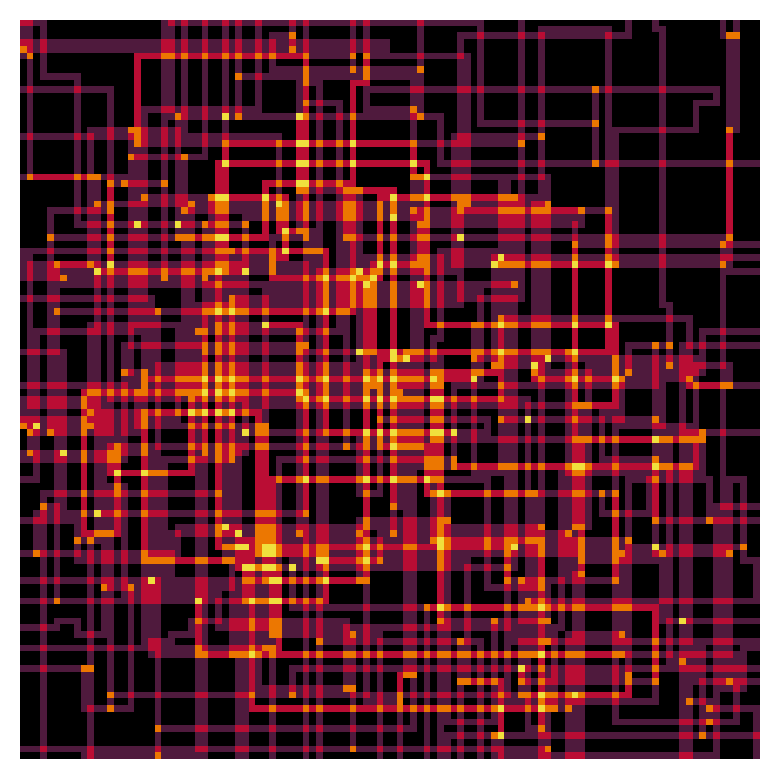

In [106]:
opticalbench.propagatebeam()
print(opticalbench.energy())
plt.imshow(opticalbench.opticalpath(),cmap="cmr.ember")
plt.axis('off')

# Part 2

In [117]:
opticalbench = OpticalBench.fromfile("input16.txt")
energies = {}
N,M = opticalbench.dims
def goaround(N,M):
    for y in range(N):
        yield Beam(0,y,Dir.E)
    for x in range(M):
        yield Beam(x,N-1,Dir.N)
    for y in range(N-1,-1,-1):
        yield Beam(M-1,y,Dir.W)
    for x in range(M-1,-1,-1):
        yield Beam(x,0,Dir.S)

        

imageStack =[]
for inibeam in goaround(*opticalbench.dims):
    opticalbench.reset(inibeam)
    opticalbench.propagatebeam()
    energies[(inibeam.x,inibeam.y,inibeam.dir)] = opticalbench.energy()
    imageStack.append(opticalbench.opticalpath())



MovieWriter ffmpeg unavailable; using Pillow instead.


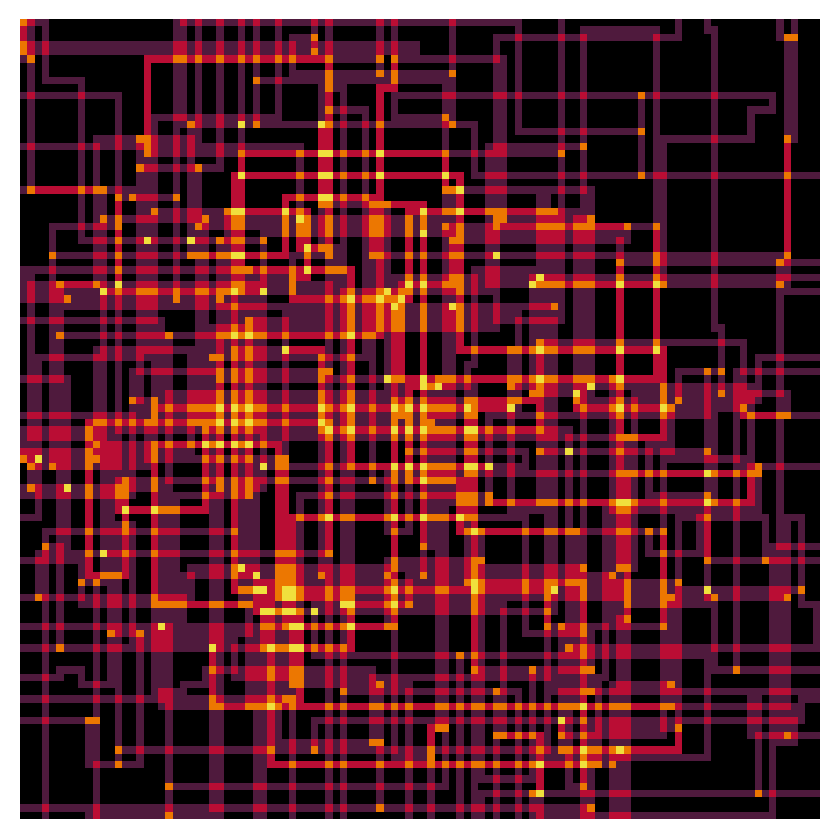

In [120]:
import matplotlib.animation as animation
fig = plt.figure(frameon=False)
fig.set_size_inches(4,4)


ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
movieImage = ax.imshow(imageStack[0], aspect='auto',vmin=0,vmax=4,cmap="cmr.ember")
def animate(i):
    movieImage.set_array(imageStack[i])
    time_text.set_text(f't={i}')
    return movieImage
anim = animation.FuncAnimation(fig,animate,frames=len(imageStack),interval=100);
anim.save('lasers.gif')

In [101]:
max(energies.values())

8183

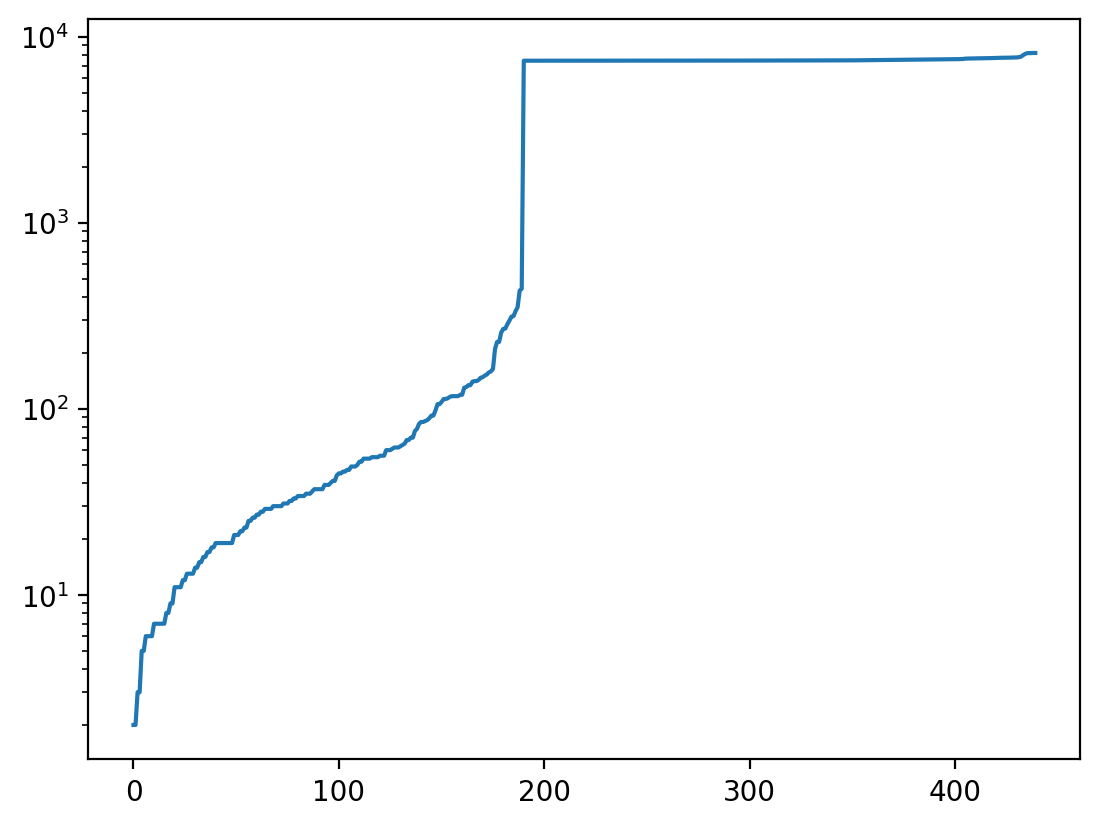

In [122]:
plt.semilogy(sorted(energies.values()))